# 2.1 Expérimentation avec l’algorithme approximative Nearest Neighbors (plus proches voisins approximatifs)


## Informations: Code executé en local pour raison de cluster indisponible
Consequence:
    -reduction de l'entré a ce qui est indiqué au min :5000-10000 tweets train et 500 tweets test

### 2.1.1 Faire une synthèse de l’article avec au minimum 2 pages et un maximum de 3 pages

### 2.1.2 Construire un classeur binaire capable de classer les tweets en deux classes : positive et négative, selon les 4 scénarios suivants du dataset :


In [1]:
data_file_csv = "./data/source.csv"
import os, sys

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

# creation session scpark:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .master("local[7]")   # 7 threads CPU (sur 8 cœurs)
    .appName("AADM")
    .config("spark.driver.memory", "12g")
    .config("spark.executor.memory", "12g")
    .config("spark.sql.shuffle.partitions", "14")   # ~2x le nb de threads
    .config("spark.default.parallelism", "14")      # ~2x le nb de threads
    .getOrCreate()
)

In [2]:
from pyspark.sql.functions import col, regexp_replace

#On charger le CSV
def load_csv(file_path):
    df = spark.read.csv(file_path,header=False,inferSchema=True)
    return df

def nettoie_df(df,neutre = False,aff=False):
    # on nomme les colones
    df = df.toDF("label", "id", "date", "flag", "user", "text")

    #on allege:
    df = df.select("id","label", "text")

    #on filtre pour
    #Nettoyer les données : suppression des mots non-pertinents, articles, urls. 
    if(neutre):
        df = df.filter(col("label").isin(0, 2 , 4))
    else:
        df = df.filter(col("label").isin(0, 4))
    df = df.withColumn("text", regexp_replace(col("text"), r"http\S+", ""))
    df = df.withColumn("text", regexp_replace(col("text"), r"@\w+", ""))
    df = df.withColumn("text", regexp_replace(col("text"), r"[^a-z\s]", ""))
    df = df.withColumn("text", regexp_replace(col("text"), r"\s+", " "))
    if(aff):
        df.show(5, truncate=False)
    return df

execution:

In [3]:
df = load_csv(data_file_csv)
df_propre = nettoie_df(df)

ensuite on creer une version du df avec des labels en binaire:

fonction:

In [4]:
from pyspark.sql.functions import when

def build_df_label_bin(df):
    df = df.withColumn("label_bin", when(col("label") == 4, 1).otherwise(0)) # pour passer de 0-4 a 0-1
    return df.select("id","label_bin", "text")

# pour la question 2.1.10 on prend de l'avance
def build_df_label_mc(df):
    df = df.withColumn(
        "label_mc",
        when(col("label") == 0, 0)
        .when(col("label") == 2, 1)
        .when(col("label") == 4, 2)
    )
    return df.select("id", "label_mc", "text")

execution:

In [5]:
df_label_bin = build_df_label_bin(df_propre)
print(df_label_bin.count())

1600000


2) On creer les scenarios

fonctions:

In [6]:
from pyspark.sql.functions import col, concat, explode, collect_list,coalesce, array,size
from pyspark.ml.feature import Tokenizer, NGram, HashingTF

num_features = 1<<18

def make_df_Tokenizer(df_label):
    tok = Tokenizer(inputCol="text", outputCol="tokens") #conversion en tokens
    df_tok = tok.transform(df_label)
    return df_tok.filter(size(col("tokens")) > 0)#sinon ca crash lors des predictions

def make_df_NGram(df,ngram_n=2,outputCol="ngrams",inputCol="tokens"):
    ng = NGram(n=ngram_n, inputCol=inputCol, outputCol=outputCol)#creation des n grams
    df_ng = ng.transform(df).filter(size(col(outputCol)) > 0)
    return df_ng

def make_s1_words(df,label_name="label_bin"):
    df_tok = make_df_Tokenizer(df)
    tf = HashingTF(inputCol="tokens", outputCol="features", numFeatures=num_features, binary=True)
    return tf.transform(df_tok).select("id",label_name, "features")

def make_s2_ngrams(df, ngram_n=2,label_name="label_bin"):
    df_tok = make_df_Tokenizer(df)
    df_ng = make_df_NGram(df_tok,ngram_n)
    tf = HashingTF(inputCol="ngrams", outputCol="features", numFeatures=num_features, binary=True)
    return tf.transform(df_ng).select("id",label_name, "features")

def make_s3_patterns(df, ngram_n=2, topN=200000,label_name="label_bin"):
    df_tok = make_df_Tokenizer(df)
    df_pat0 = make_df_NGram(df_tok, ngram_n, "patterns")

    top = (df_pat0 #on creer le top
        .select(explode("patterns").alias("p"))
        .groupBy("p").count()
        .orderBy(col("count").desc())
        .limit(topN)
        .select("p")
    )

    df_pat = (df_pat0 #on filtre selon le top
        .withColumn("p", explode("patterns"))
        .join(top, on="p", how="left_semi")
        .groupBy("id", label_name)
        .agg(collect_list("p").alias("patterns_f"))
    )

    tf = HashingTF(inputCol="patterns_f", outputCol="features", numFeatures=num_features, binary=True)
    return tf.transform(df_pat).select("id",label_name, "features")

def make_s4_combo(df, ngram_n=2, topN=200000,label_name="label_bin"):
    #on refait les 3 senarios 
    df_tok = make_df_Tokenizer(df)

    df_ng = make_df_NGram(df_tok, ngram_n, "ngrams")

    df_pat0 = make_df_NGram(df_tok, ngram_n, "patterns")

    top = (df_pat0
        .select(explode("patterns").alias("p"))
        .groupBy("p").count()
        .orderBy(col("count").desc())
        .limit(topN)
        .select("p")
    )

    df_pat = (df_pat0
        .select("id", label_name, "patterns")
        .withColumn("p", explode("patterns"))
        .join(top, on="p", how="left_semi")
        .groupBy("id", label_name)
        .agg(collect_list("p").alias("patterns_f"))
    )

    df_all = (df_ng
        .select("id", label_name, "tokens", "ngrams")
        .join(df_pat.select("id", "patterns_f"), on="id", how="left")
        .withColumn("patterns_f", coalesce(col("patterns_f"), array()))
    )

    df_combo = df_all.withColumn("combo", concat(col("tokens"), col("ngrams"), col("patterns_f"))).filter(size(col("combo")) > 0)

    tf = HashingTF(inputCol="combo", outputCol="features", numFeatures=num_features, binary=True)
    return tf.transform(df_combo).select("id",label_name, "features")



3) Construction d’un classifieur binaire pour la classification des tweets

L’objectif est de construire un classifieur binaire capable de distinguer les tweets positifs et négatifs.
Dans cette section, nous définissons l’ensemble des fonctions utilitaires qui seront utilisées dans les parties 2.1.2 à 2.1.9. Ces fonctions permettront de structurer le travail, de factoriser le code et de faciliter les expérimentations ultérieures.

Nous commençons par définir une fonction permettant de séparer le jeu de données en ensembles d’entraînement et de test.

Nous ajoutons également une fonction permettant de réduire la taille du dataset,pour la futur question 2.1.7 scalabilité

In [7]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# on split
def split_train_test(df_feat, train_ratio=0.8, label_col="label_bin", cache=True):
    w = Window.partitionBy(label_col).orderBy(F.rand())

    df_ranked = df_feat.withColumn("_rn",F.row_number().over(w)).withColumn("_cnt",F.count("*").over(Window.partitionBy(label_col)))

    train_df = df_ranked.filter(F.col("_rn") <= F.col("_cnt") * train_ratio).drop("_rn", "_cnt")

    test_df = df_ranked.filter(F.col("_rn") > F.col("_cnt") * train_ratio).drop("_rn", "_cnt")

    if cache:
        train_df = train_df.cache()
        test_df  = test_df.cache()
        print(f"split homogène => train:{train_df.count()} test:{test_df.count()}")

    return train_df, test_df

#on limite
def limit_dataset_size(df, ratio=1.0):
    if ratio >= 1.0:
        return df
    ratio = max(0,ratio)
    return df.sample(withReplacement=False, fraction=ratio)

#dans le cas ou on veux limité initialement
def limit_dataset_size_fixe_balance(df, train_rows=5000, test_rows=500, label_col="label_bin"):
    total = train_rows + test_rows
    n_classes = df.select(label_col).distinct().count()
    if n_classes == 0:
        return df.limit(0), 0.0

    per_class = max(1, total // n_classes)

    df_small = (
        df.withColumn("_r", F.row_number().over(
            Window.partitionBy(label_col).orderBy(F.rand())
        ))
        .filter(F.col("_r") <= per_class)
        .drop("_r")
        .orderBy(F.rand())
        .limit(total)
    )

    frac_used = round(train_rows / total,2)
    return df_small, frac_used

ensuite on creer les fonctions qui vont faire l'Entraînement (MinHashLSH):

In [8]:
from pyspark.ml.feature import MinHashLSH
import time
# pour les focntions suivantes
#  On recupere la construction dans l'exemple: LSHMinHash_datasetNetFlix.ipynb

def fit_lsh(train_df, numHashTables, measure_time=False):
    mh = MinHashLSH(
        inputCol="features",
        outputCol="hashes",
        numHashTables=numHashTables
    )
    
    train_df = train_df.cache()
    train_df.count()
    
    if(measure_time):
        start = time.perf_counter()
    
    lsh_model = mh.fit(train_df)
    lsh_model.transform(train_df).count() # test pas final pour voir si ca change le temps d'execution
    
    if measure_time: #c'est dans les cas plus tard ou on voudra le temps 
        end = time.perf_counter()
        return lsh_model, float(end - start)
    return lsh_model

def train_models_for_scenario( train_df, numHashTables_list=(128, 250), measure_time=False):
    models = {}
    times  = {}
    for nht in numHashTables_list:
        if measure_time:
            model, t = fit_lsh(train_df, numHashTables=int(nht), measure_time=True)
            models[int(nht)] = model
            times[int(nht)]  = t
        else:
            models[int(nht)] = fit_lsh(train_df, numHashTables=int(nht), measure_time=False)

    if measure_time:
            return models, times
    return models

Fonctions pour prédiction AkNN + vote:

In [9]:
from pyspark.sql import functions as F
from tqdm import tqdm # pour debug

def predict_knn_multi_k_from_maxK_rows(lsh_model,train_df,test_df,k_list=(50,100,150,200),label_name="label_bin",max_test=None):
    k_list = sorted([int(k) for k in k_list])
    max_k = k_list[-1]

    df_test = test_df
    if max_test is not None:
        df_test = df_test.limit(int(max_test))

    test_rows = df_test.select("id", label_name, "features").collect()
    out = {k: [] for k in k_list} # pour utiliser le nouvelle accuracy qui ne fait plus crash normalement
    for r in tqdm(test_rows, desc="KNN approxNearestNeighbors", unit="test"):
        test_id = r["id"]
        true_label = int(r[label_name])
        target_key = r["features"]

        nn_max = lsh_model.approxNearestNeighbors(train_df, target_key, int(max_k), distCol="JaccardDist")
        neigh_labels = [int(x[label_name]) for x in nn_max.select(label_name).collect()]

        for k in k_list:
            topk = neigh_labels[:k]
            if not topk:
                pred = 0
            else:
                counts = {}
                for lab in topk:
                    counts[lab] = counts.get(lab, 0) + 1
                pred = sorted(counts.items(), key=lambda x: (-x[1], x[0]))[0][0]

            out[k].append((test_id, true_label, int(pred)))

    return out

def accuracy_from_rows(rows):# calculs a la main dans les autres cas ca cassé python et je sais pas pk
    if not rows:
        return 0.0
    ok = 0
    n = 0
    for _, y, yhat in rows:
        if y is None or yhat is None:
            continue
        n += 1
        ok += int(int(yhat) == int(y))
    return ok / n if n > 0 else 0.0

def evaluate_k_grid(lsh_model, train_df, test_df, k_list=(50,100,150,200), label_name="label_bin", max_test=None):
    pred_rows_by_k = predict_knn_multi_k_from_maxK_rows(
        lsh_model, train_df, test_df,
        k_list=k_list,
        label_name=label_name,
        max_test=max_test
    )

    results = {}
    for k, rows in pred_rows_by_k.items():
        results[int(k)] = accuracy_from_rows(rows)
    return results


#### Point important: 
Apres plusieur essaie le temps d'entrainement est de l'ordre de 0 or ce n'est pas normale la solution utliser/ mis en place c'est de faire une mini évalaution avec les datas de train pour avoir un apercu de la boucle complet et pouvoir avoir une echelle pour comparer les reulat dans le cas contraire nos resultat tourne autour de 0.04 de facon aleatoire entre les modeles ce qui est inutiles 

In [10]:
#Puisque le train est preque instantané on ajoute une focntion qui sera la pour evaluer apres avoir entrainé dans le benchmaarck, fonction ajouté apres pour essayer de debug les graphs
def petite_evaluation(lsh_model,train_df,max_k=50,n_queries=100): 
    # on prend quelques requêtes depuis le train (features déjà calculées)
    query_rows = train_df.select("features").limit(int(n_queries)).collect()

    t0 = time.perf_counter()
    for r in tqdm(query_rows, desc="ANN queries", unit="query"):
        target_key = r["features"]
        # action pour forcer l'exécution Spark
        lsh_model.approxNearestNeighbors(train_df,target_key,int(max_k),distCol="JaccardDist").count()
    t1 = time.perf_counter()
    return float(t1 - t0)

Ensuite pour la futur question 2.1.5 on va vouloir un tableau pour comparer a l'article donc

In [11]:
import pandas as pd

def collect_results_row(scenario_name, numHashTables, k, accuracy):
    return {"scenario": scenario_name,"numHashTables": int(numHashTables),"k": int(k),"accuracy": float(accuracy)}

def build_results_table(results_rows, as_pandas=True):
    """
    Construit le tableau de résultats.
    """
    df = pd.DataFrame(results_rows)
    if as_pandas:
        return df
    return spark.createDataFrame(df)

def format_table4_like(df_results):
    """
    Met en forme le tableau
    """
    return (df_results.pivot_table(index=["scenario", "numHashTables"],columns="k",values="accuracy").sort_index())

def eval_scenario(models, train_df, test_df, scenario_name,K_LIST = (50, 100, 150, 200),label_name="label_bin", max_k_eval=50, n_queries_eval=100):
    rows = []
    eval_times = {}
    for nht, model in models.items():
        print(f"scenario:{scenario_name} nht: {nht}")
        acc_by_k = evaluate_k_grid(model, train_df, test_df, k_list=K_LIST,label_name=label_name)
        for k, acc in acc_by_k.items():
            rows.append(collect_results_row(scenario_name, nht, k, acc))

        eval_times[int(nht)] = petite_evaluation(
            model, train_df, max_k=max_k_eval, n_queries=n_queries_eval
        )
    print(f"OK: {scenario_name} évalué")    
    return rows,eval_times

Fonction pour l'Histogramme pour la question 2.1.6

In [12]:
import matplotlib.pyplot as plt

def times_total_to_df(scenario_name, train_times_dict, eval_times_dict):
    # train_times_dict : {128: t_fit, 250: t_fit}
    # eval_times_dict  : {128: t_eval, 250: t_eval}
    rows = []
    for nht, t_fit in train_times_dict.items():
        t_eval = eval_times_dict.get(int(nht), None)
        rows.append({
            "scenario": scenario_name,
            "numHashTables": int(nht),
            "train_time_seconds": float(t_fit) + (float(t_eval) if t_eval is not None else 0.0)
        })
    return pd.DataFrame(rows)

def plot_training_histogram(df_results, group_by=("scenario","numHashTables"), value_col="train_time_seconds"):
    dfp = df_results.copy()
    dfp["group"] = dfp[list(group_by)].astype(str).agg(" | ".join, axis=1)

    agg = dfp.groupby("group")[value_col].mean()

    plt.figure()
    agg.plot(kind="bar")
    plt.xlabel("Modèle (scénario | numHashTables)")
    plt.ylabel("Temps d'entraînement (s)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

Ensuite les fonctions pour la 2.1.7, la scalabilité

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

def benchmark_scalability_vs_fraction(train_df,scenario_name,numHashTables,F_list=(0.2, 0.4, 0.6, 0.8, 1.0),max_k=50,n_queries=100):
    rows = []
    for F in F_list:
        print(f"scenario_name : {scenario_name} numHashTables : {numHashTables}, F: {F}")
        train_df_reduit = limit_dataset_size(train_df, ratio=F)
        train_df_reduit.count()

        model, t_fit = fit_lsh(train_df_reduit,numHashTables=numHashTables,measure_time=True)

        # 3) petite évaluation
        t_query = petite_evaluation(model,train_df_reduit,max_k=max_k,n_queries=n_queries) # en faisant cette evaluation on a des temps plus cohernt
        rows.append({
            "scenario": scenario_name,
            "numHashTables": int(numHashTables),
            "F": float(F),
            "time_seconds": float(t_fit) + float(t_query)
        })

    return pd.DataFrame(rows)

#Plot Figure 3
def plot_scalability_fraction(df_scaling, hue="scenario"):
    plt.figure()

    if hue in df_scaling.columns:
        for key, g in df_scaling.groupby(hue):
            g2 = g.groupby("F")["time_seconds"].mean().sort_index()
            plt.plot(g2.index, g2.values, marker="o", label=str(key))
        plt.legend()
    else:
        g2 = df_scaling.groupby("F")["time_seconds"].mean().sort_index()
        plt.plot(g2.index, g2.values, marker="o")

    plt.xlabel("F (fraction de la taille originale)")
    plt.ylabel("Temps d'entraînement (s)")
    plt.tight_layout()
    plt.show()

Pour la question 2.1.9, focntion simple:

In [14]:
def add_signatures(lsh_model, df_feat):
    """
    Ajoute la colonne 'hashes' (signature MinHash) au DataFrame de features.
    """
    return lsh_model.transform(df_feat)

def show_signature_examples(df_with_hashes, n=5, cols=("id", "label_bin", "hashes")):
    df_with_hashes.select(*cols).show(n, truncate=False)


### 2.1.3 Entrainer simplement chacun des 4 classeurs sans validation croisée. Le réglage des paramètres de l’algorithme approxNearestNeighbos sera uniquement sur le nombre de fonctions de hachages « numHashTables » du MinHash. Utiliser une plage de 2 valeurs maximum, par exemple {128, 250} afin de trouver la bonne longueur de la meilleure signature (réduction de dimensionnalité) 

reduction en local: (sinon mon ordi ne supporte pas) et split initial

In [15]:
NUM_HASH_LIST = (128, 250)
ratio_pour_split = 0.9

df_travail, ratio_pour_split = limit_dataset_size_fixe_balance(df_label_bin, 10000, 500)
print("taille df_travail:", df_travail.count(), "ratio split:", ratio_pour_split)


taille df_travail: 10500 ratio split: 0.95


préparation:

In [16]:
df_s1_all = make_s1_words(df_travail).cache(); df_s1_all.count()
df_s2_all = make_s2_ngrams(df_travail).cache(); df_s2_all.count()
df_s3_all = make_s3_patterns(df_travail).cache(); df_s3_all.count()
df_s4_all = make_s4_combo(df_travail).cache(); df_s4_all.count()


10408

split:

In [17]:
train_s1, test_s1 = split_train_test(df_s1_all, train_ratio=ratio_pour_split, cache=True)
train_s2, test_s2 = split_train_test(df_s2_all, train_ratio=ratio_pour_split, cache=True)
train_s3, test_s3 = split_train_test(df_s3_all, train_ratio=ratio_pour_split, cache=True)
train_s4, test_s4 = split_train_test(df_s4_all, train_ratio=ratio_pour_split, cache=True)

split homogène => train:9910 test:523
split homogène => train:9886 test:522
split homogène => train:9886 test:522
split homogène => train:9886 test:522


train:

In [18]:
models_s1, times_s1 = train_models_for_scenario(train_s1, numHashTables_list=NUM_HASH_LIST, measure_time=True)
models_s2, times_s2 = train_models_for_scenario(train_s2, numHashTables_list=NUM_HASH_LIST, measure_time=True)
models_s3, times_s3 = train_models_for_scenario(train_s3, numHashTables_list=NUM_HASH_LIST, measure_time=True)
models_s4, times_s4 = train_models_for_scenario(train_s4, numHashTables_list=NUM_HASH_LIST, measure_time=True)

print("OK: modèles entraînés pour S1..S4 avec numHashTables =", NUM_HASH_LIST)

OK: modèles entraînés pour S1..S4 avec numHashTables = (128, 250)


### 2.1.4 Tester les classeurs obtenus et mesurer l’exactitude « accuracy » selon les différentes valeurs de k plus proches voisins : {50, 100, 150, 200}

In [19]:
results_rows = []
eval_times_all = {}

rows, t_eval= eval_scenario(models_s1, train_s1, test_s1, "S1_words")
results_rows += rows
eval_times_all["S1_words"] = t_eval

rows, t_eval = eval_scenario(models_s2, train_s2, test_s2, "S2_ngrams")
results_rows += rows
eval_times_all["S2_ngrams"] = t_eval

rows, t_eval = eval_scenario(models_s3, train_s3, test_s3, "S3_patterns")
results_rows += rows
eval_times_all["S3_patterns"] = t_eval

rows, t_eval = eval_scenario(models_s4, train_s4, test_s4, "S4_combo")
results_rows += rows
eval_times_all["S4_combo"] = t_eval

scenario:S1_words nht: 128


ANN queries: 100%|██████████| 100/100 [00:53<00:00,  1.87query/s]


scenario:S1_words nht: 250


ANN queries: 100%|██████████| 100/100 [01:38<00:00,  1.02query/s]


OK: S1_words évalué
scenario:S2_ngrams nht: 128


ANN queries: 100%|██████████| 100/100 [00:51<00:00,  1.93query/s]


scenario:S2_ngrams nht: 250


ANN queries: 100%|██████████| 100/100 [01:41<00:00,  1.02s/query]


OK: S2_ngrams évalué
scenario:S3_patterns nht: 128


ANN queries: 100%|██████████| 100/100 [00:55<00:00,  1.79query/s]


scenario:S3_patterns nht: 250


ANN queries: 100%|██████████| 100/100 [01:37<00:00,  1.02query/s]


OK: S3_patterns évalué
scenario:S4_combo nht: 128


ANN queries: 100%|██████████| 100/100 [01:19<00:00,  1.26query/s]


scenario:S4_combo nht: 250


ANN queries: 100%|██████████| 100/100 [02:39<00:00,  1.59s/query]

OK: S4_combo évalué


### 2.1.5 Tracer le tableau des performances de classification, à l’image de la table 4 de l’article,selon les différents modèles de classeurs obtenus

In [22]:
df_results = build_results_table(results_rows)     
df_table4  = format_table4_like(df_results)
df_table4

k                               50        100       150       200
scenario    numHashTables                                        
S1_words    128            0.655832  0.667304  0.669216  0.669216
            250            0.655832  0.667304  0.669216  0.667304
S2_ngrams   128            0.655172  0.666667  0.660920  0.662835
            250            0.659004  0.664751  0.659004  0.660920
S3_patterns 128            0.620690  0.626437  0.628352  0.628352
            250            0.620690  0.630268  0.632184  0.630268
S4_combo    128            0.670498  0.689655  0.683908  0.649425
            250            0.670498  0.687739  0.681992  0.653257

### 2.1.6 Tracer le graphique (histogramme) du temps d’entrainement, à l’image de la figure 2 en mesurant le temps d’entrainement pour les différents modèles

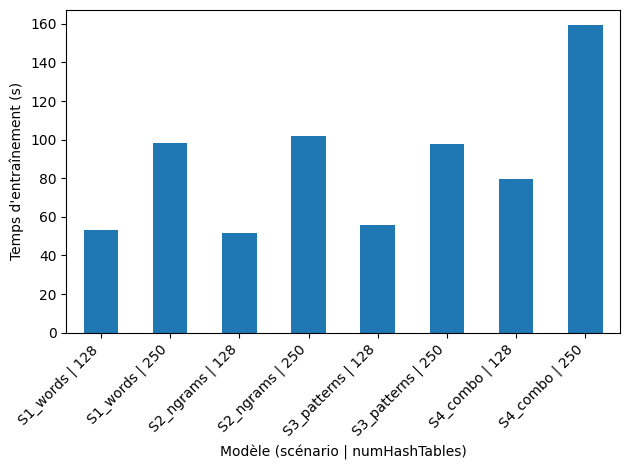

In [ ]:
df_time = pd.concat([
    times_total_to_df("S1_words",    times_s1, eval_times_all["S1_words"]),
    times_total_to_df("S2_ngrams",   times_s2, eval_times_all["S2_ngrams"]),
    times_total_to_df("S3_patterns", times_s3, eval_times_all["S3_patterns"]),
    times_total_to_df("S4_combo",    times_s4, eval_times_all["S4_combo"]),
], ignore_index=True)

plot_training_histogram(df_time,group_by=("scenario", "numHashTables"),value_col="train_time_seconds")

### 2.1.7 Tracer la courbe du passage à l’échelle -scalability-, à l’image de la figure 3 de l’article,pour chaque modèle entrainé

scenario_name : S1_words numHashTables : 128, F: 0.2


ANN queries: 100%|██████████| 100/100 [00:13<00:00,  7.21query/s]


scenario_name : S1_words numHashTables : 128, F: 0.4


ANN queries: 100%|██████████| 100/100 [00:23<00:00,  4.24query/s]


scenario_name : S1_words numHashTables : 128, F: 0.6


ANN queries: 100%|██████████| 100/100 [00:34<00:00,  2.87query/s]


scenario_name : S1_words numHashTables : 128, F: 0.8


ANN queries: 100%|██████████| 100/100 [00:44<00:00,  2.23query/s]


scenario_name : S1_words numHashTables : 128, F: 1.0


ANN queries: 100%|██████████| 100/100 [00:54<00:00,  1.84query/s]


scenario_name : S1_words numHashTables : 250, F: 0.2


ANN queries: 100%|██████████| 100/100 [00:22<00:00,  4.39query/s]


scenario_name : S1_words numHashTables : 250, F: 0.4


ANN queries: 100%|██████████| 100/100 [00:42<00:00,  2.35query/s]


scenario_name : S1_words numHashTables : 250, F: 0.6


ANN queries: 100%|██████████| 100/100 [01:01<00:00,  1.64query/s]


scenario_name : S1_words numHashTables : 250, F: 0.8


ANN queries: 100%|██████████| 100/100 [01:20<00:00,  1.24query/s]


scenario_name : S1_words numHashTables : 250, F: 1.0


ANN queries: 100%|██████████| 100/100 [01:38<00:00,  1.01query/s]


scenario_name : S2_ngrams numHashTables : 128, F: 0.2


ANN queries: 100%|██████████| 100/100 [00:13<00:00,  7.58query/s]


scenario_name : S2_ngrams numHashTables : 128, F: 0.4


ANN queries: 100%|██████████| 100/100 [00:23<00:00,  4.27query/s]


scenario_name : S2_ngrams numHashTables : 128, F: 0.6


ANN queries: 100%|██████████| 100/100 [00:32<00:00,  3.03query/s]


scenario_name : S2_ngrams numHashTables : 128, F: 0.8


ANN queries: 100%|██████████| 100/100 [00:42<00:00,  2.33query/s]


scenario_name : S2_ngrams numHashTables : 128, F: 1.0


ANN queries: 100%|██████████| 100/100 [00:52<00:00,  1.90query/s]


scenario_name : S2_ngrams numHashTables : 250, F: 0.2


ANN queries: 100%|██████████| 100/100 [00:22<00:00,  4.42query/s]


scenario_name : S2_ngrams numHashTables : 250, F: 0.4


ANN queries: 100%|██████████| 100/100 [00:41<00:00,  2.40query/s]


scenario_name : S2_ngrams numHashTables : 250, F: 0.6


ANN queries: 100%|██████████| 100/100 [01:01<00:00,  1.64query/s]


scenario_name : S2_ngrams numHashTables : 250, F: 0.8


ANN queries: 100%|██████████| 100/100 [01:18<00:00,  1.27query/s]


scenario_name : S2_ngrams numHashTables : 250, F: 1.0


ANN queries: 100%|██████████| 100/100 [01:38<00:00,  1.02query/s]


scenario_name : S3_patterns numHashTables : 128, F: 0.2


ANN queries: 100%|██████████| 100/100 [00:14<00:00,  7.10query/s]


scenario_name : S3_patterns numHashTables : 128, F: 0.4


ANN queries: 100%|██████████| 100/100 [00:23<00:00,  4.25query/s]


scenario_name : S3_patterns numHashTables : 128, F: 0.6


ANN queries: 100%|██████████| 100/100 [00:33<00:00,  2.97query/s]


scenario_name : S3_patterns numHashTables : 128, F: 0.8


ANN queries: 100%|██████████| 100/100 [00:42<00:00,  2.35query/s]


scenario_name : S3_patterns numHashTables : 128, F: 1.0


ANN queries: 100%|██████████| 100/100 [00:53<00:00,  1.87query/s]


scenario_name : S3_patterns numHashTables : 250, F: 0.2


ANN queries: 100%|██████████| 100/100 [00:23<00:00,  4.27query/s]


scenario_name : S3_patterns numHashTables : 250, F: 0.4


ANN queries: 100%|██████████| 100/100 [00:42<00:00,  2.36query/s]


scenario_name : S3_patterns numHashTables : 250, F: 0.6


ANN queries: 100%|██████████| 100/100 [01:00<00:00,  1.66query/s]


scenario_name : S3_patterns numHashTables : 250, F: 0.8


ANN queries: 100%|██████████| 100/100 [01:20<00:00,  1.25query/s]


scenario_name : S3_patterns numHashTables : 250, F: 1.0


ANN queries: 100%|██████████| 100/100 [01:38<00:00,  1.02query/s]


scenario_name : S4_combo numHashTables : 128, F: 0.2


ANN queries: 100%|██████████| 100/100 [00:19<00:00,  5.18query/s]


scenario_name : S4_combo numHashTables : 128, F: 0.4


ANN queries: 100%|██████████| 100/100 [00:35<00:00,  2.80query/s]


scenario_name : S4_combo numHashTables : 128, F: 0.6


ANN queries: 100%|██████████| 100/100 [00:50<00:00,  1.98query/s]


scenario_name : S4_combo numHashTables : 128, F: 0.8


ANN queries: 100%|██████████| 100/100 [01:05<00:00,  1.53query/s]


scenario_name : S4_combo numHashTables : 128, F: 1.0


ANN queries: 100%|██████████| 100/100 [01:20<00:00,  1.25query/s]


scenario_name : S4_combo numHashTables : 250, F: 0.2


ANN queries: 100%|██████████| 100/100 [00:34<00:00,  2.93query/s]


scenario_name : S4_combo numHashTables : 250, F: 0.4


ANN queries: 100%|██████████| 100/100 [01:03<00:00,  1.57query/s]


scenario_name : S4_combo numHashTables : 250, F: 0.6


ANN queries: 100%|██████████| 100/100 [01:32<00:00,  1.08query/s]


scenario_name : S4_combo numHashTables : 250, F: 0.8


ANN queries: 100%|██████████| 100/100 [02:03<00:00,  1.23s/query]


scenario_name : S4_combo numHashTables : 250, F: 1.0


ANN queries: 100%|██████████| 100/100 [02:31<00:00,  1.51s/query]


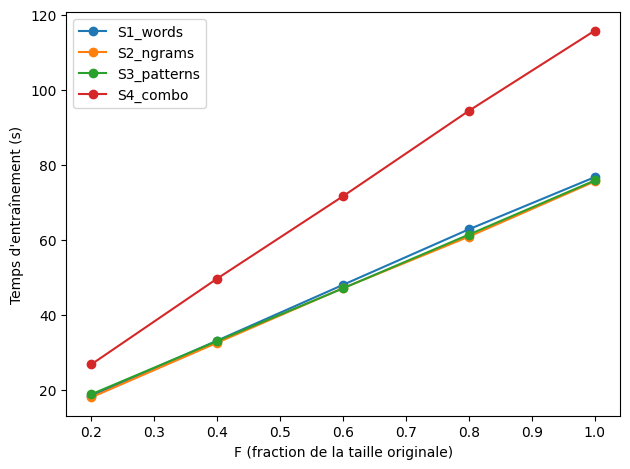

In [24]:
F_list = (0.2, 0.4, 0.6, 0.8, 1.0)

rows = []

S_all = [
            ("S1_words", train_s1),
            ("S2_ngrams", train_s2),
            ("S3_patterns", train_s3),
            ("S4_combo", train_s4),
        ]

for scenario_name, train_df_s in S_all:
    for nht in NUM_HASH_LIST:
        df_tmp = benchmark_scalability_vs_fraction(train_df=train_df_s,scenario_name=scenario_name,numHashTables=nht,F_list=F_list)
        rows.append(df_tmp)

df_scaling = pd.concat(rows, ignore_index=True)

plot_scalability_fraction(df_scaling, hue="scenario")

### 2.1.9 Afficher quelques exemples de signatures obtenues pour chaque classeur

In [25]:
N_EXAMPLES = 2
NHT = NUM_HASH_LIST[0]

S_all_model_data = [
    ("S1_words", models_s1, train_s1),
    ("S2_ngrams", models_s2, train_s2),
    ("S3_patterns", models_s3, train_s3),
    ("S4_combo", models_s4, train_s4),
]

for scenario_name, models, train_df in S_all_model_data:
    print(f"\n=== {scenario_name} | numHashTables={NHT} ===")

    lsh_model = models[NHT]

    df_with_hashes = add_signatures(lsh_model, train_df)

    show_signature_examples(
        df_with_hashes,
        n=N_EXAMPLES
    )



=== S1_words | numHashTables=128 ===
+----------+---------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 2.1.10 Pour pouvoir comparer avec les résultats de l’article, entrainer cette fois-ci, un classeur multi-classes en ajoutant la classe « neutre » tout en répétant les étapes précédentes : 2-1-2 à 2-1-9

On construit le nouveau df:

In [15]:
df_propre = nettoie_df(df,True)
df_mc = build_df_label_mc(df_propre)

LABEL_NAME = "label_mc"
NUM_HASH_LIST = (128, 250)
ratio_pour_split = 0.9

df_travail, ratio_pour_split = limit_dataset_size_fixe_balance(df_mc, 10000, 500,label_col=LABEL_NAME)
print("taille df_travail:", df_travail.count(), "ratio split:", ratio_pour_split)

taille df_travail: 10500 ratio split: 0.95


On commence par refaire le 2.1.3:

In [16]:
df_s1_all = make_s1_words(df_travail,label_name=LABEL_NAME)
df_s2_all = make_s2_ngrams(df_travail,label_name=LABEL_NAME)
df_s3_all = make_s3_patterns(df_travail,label_name=LABEL_NAME)
df_s4_all = make_s4_combo(df_travail,label_name=LABEL_NAME)

#Split
train_s1, test_s1 = split_train_test(df_s1_all, train_ratio=ratio_pour_split, cache=True,label_col=LABEL_NAME)
train_s2, test_s2 = split_train_test(df_s2_all, train_ratio=ratio_pour_split, cache=True,label_col=LABEL_NAME)
train_s3, test_s3 = split_train_test(df_s3_all, train_ratio=ratio_pour_split, cache=True,label_col=LABEL_NAME)
train_s4, test_s4 = split_train_test(df_s4_all, train_ratio=ratio_pour_split, cache=True,label_col=LABEL_NAME)

#Entraînement
models_s1, times_s1 = train_models_for_scenario(train_s1, numHashTables_list=NUM_HASH_LIST, measure_time=True)
models_s2, times_s2 = train_models_for_scenario(train_s2, numHashTables_list=NUM_HASH_LIST, measure_time=True)
models_s3, times_s3 = train_models_for_scenario(train_s3, numHashTables_list=NUM_HASH_LIST, measure_time=True)
models_s4, times_s4 = train_models_for_scenario(train_s4, numHashTables_list=NUM_HASH_LIST, measure_time=True)

print("OK: modèles entraînés pour S1..S4 avec numHashTables =", NUM_HASH_LIST)

split homogène => train:9890 test:522
split homogène => train:9862 test:520
split homogène => train:9862 test:520
split homogène => train:9862 test:520
OK: modèles entraînés pour S1..S4 avec numHashTables = (128, 250)


Ensuite le 2.1.4:

In [ ]:
results_rows_mc = []
eval_times_all = {}
rows_mc, t_eval = eval_scenario(models_s1, train_s1, test_s1, "S1_words_mc", label_name=LABEL_NAME)
results_rows_mc += rows_mc
eval_times_all["S1_words_mc"] = t_eval

rows_mc, t_eval = eval_scenario(models_s2, train_s2, test_s2, "S2_ngrams_mc", label_name=LABEL_NAME)
results_rows_mc += rows_mc
eval_times_all["S2_ngrams_mc"] = t_eval

rows_mc, t_eval = eval_scenario(models_s3, train_s3, test_s3, "S3_patterns_mc", label_name=LABEL_NAME)
results_rows_mc += rows_mc
eval_times_all["S3_patterns_mc"] = t_eval

rows_mc, t_eval = eval_scenario(models_s4, train_s4, test_s4, "S4_combo_mc", label_name=LABEL_NAME)
results_rows_mc += rows_mc
eval_times_all["S4_combo_mc"] = t_eval

scenario:S1_words_mc nht: 128


ANN queries: 100%|██████████| 100/100 [00:55<00:00,  1.80query/s]


scenario:S1_words_mc nht: 250


ANN queries: 100%|██████████| 100/100 [01:42<00:00,  1.02s/query]


OK: S1_words_mc évalué
scenario:S2_ngrams_mc nht: 128


ANN queries: 100%|██████████| 100/100 [00:53<00:00,  1.88query/s]


scenario:S2_ngrams_mc nht: 250


ANN queries: 100%|██████████| 100/100 [01:43<00:00,  1.03s/query]


OK: S2_ngrams_mc évalué
scenario:S3_patterns_mc nht: 128


ANN queries: 100%|██████████| 100/100 [00:55<00:00,  1.79query/s]


scenario:S3_patterns_mc nht: 250


KNN approxNearestNeighbors:  75%|███████▍  | 388/520 [06:52<02:20,  1.06s/test]

2.1.5:

In [ ]:
df_results = build_results_table(results_rows_mc)     
df_table4  = format_table4_like(df_results)
df_table4

2.1.6:

In [ ]:
df_time = pd.concat([
    times_total_to_df("S1_words_mc",    times_s1, eval_times_all["S1_words_mc"]),
    times_total_to_df("S2_ngrams_mc",   times_s2, eval_times_all["S2_ngrams_mc"]),
    times_total_to_df("S3_patterns_mc", times_s3, eval_times_all["S3_patterns_mc"]),
    times_total_to_df("S4_combo_mc",    times_s4, eval_times_all["S4_combo_mc"]),
], ignore_index=True)

plot_training_histogram(df_time,group_by=("scenario", "numHashTables"),value_col="train_time_seconds")



2.1.7:

In [ ]:
F_list = (0.2, 0.4, 0.6, 0.8, 1.0)

rows = []

S_all = [
            ("S1_words", train_s1),
            ("S2_ngrams", train_s2),
            ("S3_patterns", train_s3),
            ("S4_combo", train_s4),
        ]

for scenario_name, train_df_s in S_all:
    for nht in NUM_HASH_LIST:
        df_tmp = benchmark_scalability_vs_fraction(train_df=train_df_s,scenario_name=scenario_name,numHashTables=nht,F_list=F_list)
        rows.append(df_tmp)

df_scaling = pd.concat(rows, ignore_index=True)

plot_scalability_fraction(df_scaling, hue="scenario")

2.1.9

In [ ]:
N_EXAMPLES = 2
NHT = NUM_HASH_LIST[0]

S_all_model_data = [
    ("S1_words", models_s1, train_s1),
    ("S2_ngrams", models_s2, train_s2),
    ("S3_patterns", models_s3, train_s3),
    ("S4_combo", models_s4, train_s4),
]

for scenario_name, models, train_df in S_all_model_data:
    print(f"\n=== {scenario_name} | numHashTables={NHT} ===")
    lsh_model = models[NHT]
    df_with_hashes = add_signatures(lsh_model, train_df)
    show_signature_examples(df_with_hashes,n=N_EXAMPLES)

In [ ]:
print(df_scaling[["scenario", "numHashTables", "F", "time_seconds"]])

### 2.1.11 Une fois l’étude (2.1.1 à 2.1.10) est réalisée et démontrée, choisissez un des classeurs (binaire ou ternaire) pour intégrer un filtre de Bloom à la place d’un HashingTF. Vous pouvez réutiliser n’importe quel code trouvé sur le net pour implémenter le filtre de Bloom ! À condition qu’il faut le comprendre et le commenter

On choisit le scenario 1 c'est le moins lourd et le plus simple

BloomFilter source: https://www.youtube.com/watch?v=V3pzxngeLqw

In [ ]:
from pyspark.ml.linalg import Vectors
import hashlib

def bloom_vector_from_tokens(tokens, m, k):
    """
    Construction d’un filtre de Bloom à partir d’une liste de tokens.

    Principe (selon la vidéo) :
    - Le filtre de Bloom est un tableau de bits de taille m (bit array).
    - Pour chaque élément (token), on applique k fonctions de hachage.
    - Chaque fonction de hachage retourne une position dans [0, m-1].
    - Les bits correspondants sont mis à 1.
    - Des collisions sont possibles (faux positifs), mais aucun faux négatif.

    Adaptation au contexte Spark :
    - Le tableau de bits est représenté sous forme de SparseVector.
    - Seules les positions à 1 sont stockées.
    """

    # Cas limite : aucun token
    if tokens is None:
        # Vecteur binaire vide de taille m
        return Vectors.sparse(m, [], [])

    # Ensemble des indices activés dans le filtre de Bloom
    idx = set()

    # Pour chaque token du document
    for t in tokens:
        if not t:
            continue

        # Application de k fonctions de hachage
        # (simulées ici par le même hash avec des seeds différentes)
        for i in range(k):
            # Calcul d’un hash stable à partir du token et du seed i
            # sha256 est utilisé pour garantir un hash déterministe
            h = hashlib.sha256((t + "#" + str(i)).encode("utf-8")).digest()

            # Conversion des 8 premiers octets en entier 64 bits
            # puis projection dans l’intervalle [0, m-1]
            pos = int.from_bytes(h[:8], byteorder="little", signed=False) % m

            # Activation du bit correspondant
            idx.add(int(pos))

    # Conversion en SparseVector :
    # - idx : positions mises à 1
    # - valeurs : 1.0 pour chaque position active
    idx = sorted(idx)
    return Vectors.sparse(m, idx, [1.0] * len(idx))

On recréer le scénario 1 mais version bloom:

In [ ]:
from pyspark.sql import functions as F
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer

def make_s1_words_bloom_spark(df, label_name="label_bin", m=1<<18, k=7):
    # 1) Tokenisation (comme S1)
    tok = RegexTokenizer(inputCol="text", outputCol="tokens_raw", pattern="\\W+", toLowercase=True)
    sw  = StopWordsRemover(inputCol="tokens_raw", outputCol="tokens")
    df2 = sw.transform(tok.transform(df))

    # 2) Bloom "façon vidéo" : positions = hash(token + i) % m
    # On génère des "pseudo-tokens" représentant les bits activés : "p_<pos>"
    # explode tokens, cross join avec i in [0..k-1], calc pos, regroupe par doc.
    seeds = spark.range(0, k).withColumnRenamed("id", "seed")  # 0..k-1

    df_bits = (df2
        .select("id", F.col(label_name).alias(label_name), F.explode(F.col("tokens")).alias("t"))
        .crossJoin(seeds)
        .withColumn("pos", (F.pmod(F.hash(F.concat_ws("#", F.col("t"), F.col("seed").cast("string"))), F.lit(m))))
        .withColumn("bit_token", F.concat(F.lit("p_"), F.col("pos").cast("string")))
        .groupBy("id", label_name)
        .agg(F.collect_set("bit_token").alias("bloom_bits"))
    )

    # 3) Bit array -> SparseVector via CountVectorizer (binary=True)
    # vocabSize = m ici serait énorme (262k), CountVectorizer gère, mais peut être lourd.
    # On laisse vocabSize grand, mais tu peux réduire m pour local.
    cv = CountVectorizer(inputCol="bloom_bits", outputCol="features", binary=True, vocabSize=m, minDF=1.0)

    cv_model = cv.fit(df_bits)
    out = cv_model.transform(df_bits).select("id", label_name, "features")
    return out


Préparation:

In [ ]:
LABEL_NAME = "label_bin"
NUM_HASH_LIST = (128, 250)
ratio_pour_split = 0.8
K_LIST = (50,100,150,200)

df_label_bin = build_df_label_bin(df_propre)
df_travail, ratio_pour_split = limit_dataset_size_fixe_balance(df_mc, 5000, 300,label_col=LABEL_NAME)

# HashingTF (S1)
df_s1_hash = make_s1_words(df_travail, label_name=LABEL_NAME).cache()
df_s1_hash.count()

# Bloom (S1 Bloom)
df_s1_bloom = make_s1_words_bloom_spark(df_travail, label_name=LABEL_NAME, m=1<<16, k=7).cache()
df_s1_bloom.count()


Split:

In [ ]:
train_hash, test_hash = split_train_test(df_s1_hash, train_ratio=ratio_pour_split, cache=True, label_col=LABEL_NAME)
train_bloom, test_bloom = split_train_test(df_s1_bloom, train_ratio=ratio_pour_split, cache=True, label_col=LABEL_NAME)

Entraînement:

In [ ]:
models_hash, times_hash = train_models_for_scenario(train_hash, numHashTables_list=NUM_HASH_LIST, measure_time=True)
models_bloom, times_bloom = train_models_for_scenario(train_bloom, numHashTables_list=NUM_HASH_LIST, measure_time=True)

Évaluation:

In [ ]:
rows_hash, eval_times_hash = eval_scenario(models_hash, train_hash, test_hash,scenario_name="S1_HASHINGTF",K_LIST=K_LIST, label_name=LABEL_NAME)
rows_bloom, eval_times_bloom = eval_scenario(models_bloom, train_bloom, test_bloom,scenario_name="S1_BLOOM",K_LIST=K_LIST, label_name=LABEL_NAME)

df_results_hash = pd.DataFrame(rows_hash)
df_results_bloom = pd.DataFrame(rows_bloom)
df_results_all = pd.concat([df_results_hash, df_results_bloom], ignore_index=True)


Table accuracy: 

In [ ]:
df_acc = (df_results_all
    .pivot_table(index=["scenario","numHashTables"], columns="k", values="acc")
    .reset_index()
)
df_acc

Comparaison entraînement:

In [ ]:
df_time = pd.concat([
    times_total_to_df("S1_HASHINGTF", times_hash, eval_times_hash),
    times_total_to_df("S1_BLOOM",     times_bloom, eval_times_bloom),
], ignore_index=True)

plot_training_histogram(df_time, group_by=("scenario","numHashTables"), value_col="train_time_seconds")

Graph scalabilité:

In [ ]:
F_list = (0.2, 0.4, 0.6, 0.8, 1.0)

df_scaling = pd.concat([
    benchmark_scalability_vs_fraction(df_s1_hash,scenario_name="S1_HASHINGTF",numHashTables=128,F_list=F_list),
    benchmark_scalability_vs_fraction(df_s1_bloom,scenario_name="S1_BLOOM",numHashTables=128,F_list=F_list)
], ignore_index=True)

plot_scalability_fraction(df_scaling, hue="scenario")

Comparasion plot:

In [ ]:
def plot_acc_vs_k(df_results, title=""):
    import matplotlib.pyplot as plt
    plt.figure()
    for (sc, nht), g in df_results.groupby(["scenario", "numHashTables"]):
        g2 = g.sort_values("k")
        plt.plot(g2["k"], g2["acc"], marker="o", label=f"{sc} | nht={nht}")
    plt.xlabel("k")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_acc_vs_k(pd.concat([df_results_hash, df_results_bloom], ignore_index=True),title="S1 : HashingTF vs Bloom")